In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train_regression import *
from dtw import *

import math
import wandb
import torch
import torchaudio
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from easydict import EasyDict

device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_model(uuid):
    api = wandb.Api()
    runs = api.runs('yermandy/vehicle-audio-nn', per_page=1000, order='config.uuid')

    for run in runs: 
        if run.name == str(uuid):
            params = EasyDict(run.config)
            params.val_loss_best = run.summary['val loss best']
            break
            
    split_indices = get_split_indices(params)
    
    params.model = params.model if 'model' in params else 'ResNet18'

    if params.model == 'MobileNetV3S':
        model = MobileNetV3S()
    elif params.model == 'MobileNetV3L':
        model = MobileNetV3L()
    else:
        model = ResNet18()
    model = model.to(device)
        
    weights = torch.load(f'weights/regression/model_{uuid}_diff.pth', device)
    model.load_state_dict(weights)
    return model, params


def plot_nn_outputs(T, E, results, directions=None):
    # results = np.convolve(results, np.ones(3), 'valid')

    fig, ax1 = plt.subplots(figsize=(60, 6))
    ax2 = ax1.twinx()
    ax1.plot(T, results)

    for i in range(int(np.max(results))):
        ax1.hlines(i + 1, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)

    color = 'r'
    
    for i, event in enumerate(E):
        if directions is not None:
            color = 'r' if directions[i] == 'outgoing' else 'g'
        ax2.vlines(event, 0, 1, color=color, linewidth=1.0)
     
    
def plot_nn_cumsum(T, E, results):
    cumsum = np.cumsum(results)

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(np.append(E, T[-1]), range(len(E) + 1), where='post');

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
def plot_nn_cumsum_2(T, E, results, directions=None):
    cumsum = np.cumsum(results)
    cumstep = get_cumstep(T, E)

    print(f'diff: {np.abs(cumsum - cumstep).mean():.4f}')

    fig, ax = plt.subplots(figsize=(60, 6))
    ax2 = ax.twinx()
    ax.plot(T, cumsum)
    ax.step(T, cumstep, where='post');

    color = 'r'
    
    for i, event in enumerate(E):
        if directions is not None:
            color = 'r' if directions[i] == 'outgoing' else 'g'
        ax2.vlines(event, 0, 1, color=color, linewidth=1.0)
        
def plot_events_density(loader):
    events_per_window = []
    for x, y in loader:
        y = y.numpy()
        events_per_window.extend(y)

    fig, ax = plt.subplots()
    labels, counts = np.unique(events_per_window, return_counts=True)
    print(counts)
    ax.bar(labels, counts, align='center')
    ax.set_xticks(labels);
    
def test(uuid, FROM_TIME, TILL_TIME):
    model, params = load_model(uuid)

    dataset = VehicleDataset(signal, events, start_time=FROM_TIME, end_time=TILL_TIME, seed=0, params=params)
    loader = DataLoader(dataset, batch_size=64)
    
    params.val = get_additional_params(
        params, signal, events, start_time=FROM_TIME, end_time=TILL_TIME
    )

    val_results = validate(model, dataset, params.val, tqdm=tqdm)
    
    return val_results, params, loader


def inference(uuid, signal, FROM_TIME, TILL_TIME):
    model, params = load_model(uuid)
    
    dataset = VehicleDataset(torch.tensor([]), np.array([]), start_time=0, end_time=0, seed=0, params=params)

    params.val = get_additional_params(
        params, signal, start_time=FROM_TIME, end_time=TILL_TIME
    )
    
    results = validate(model, dataset, params.val, tqdm=tqdm)
    
    return results, params

In [29]:
signal = load_audio('data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav')
events = load_events('data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt')

In [30]:
uuid = 1628531371
FROM_TIME = 25 * 60
TILL_TIME = 34 * 60    

results, params, loader = test(uuid, FROM_TIME, TILL_TIME)

  0%|          | 0/1079 [00:00<?, ?it/s]

In [31]:
x, y = next(iter(loader))
print(x.shape)

torch.Size([64, 1, 72, 1895])


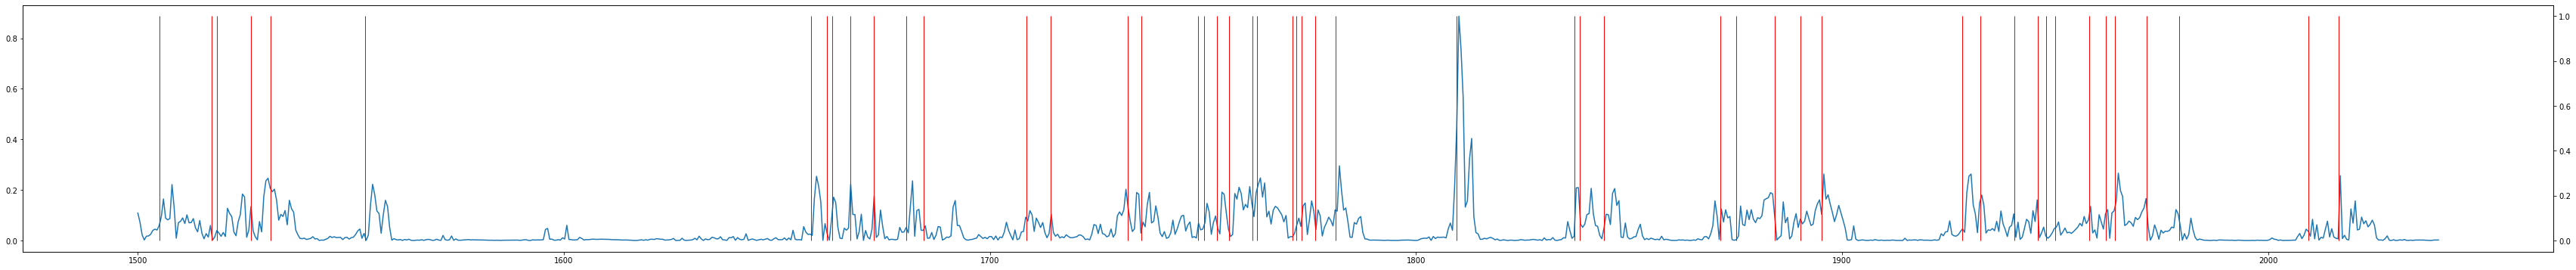

In [32]:
plot_nn_outputs(params.val.time, params.val.events, results)

diff: 1.2320


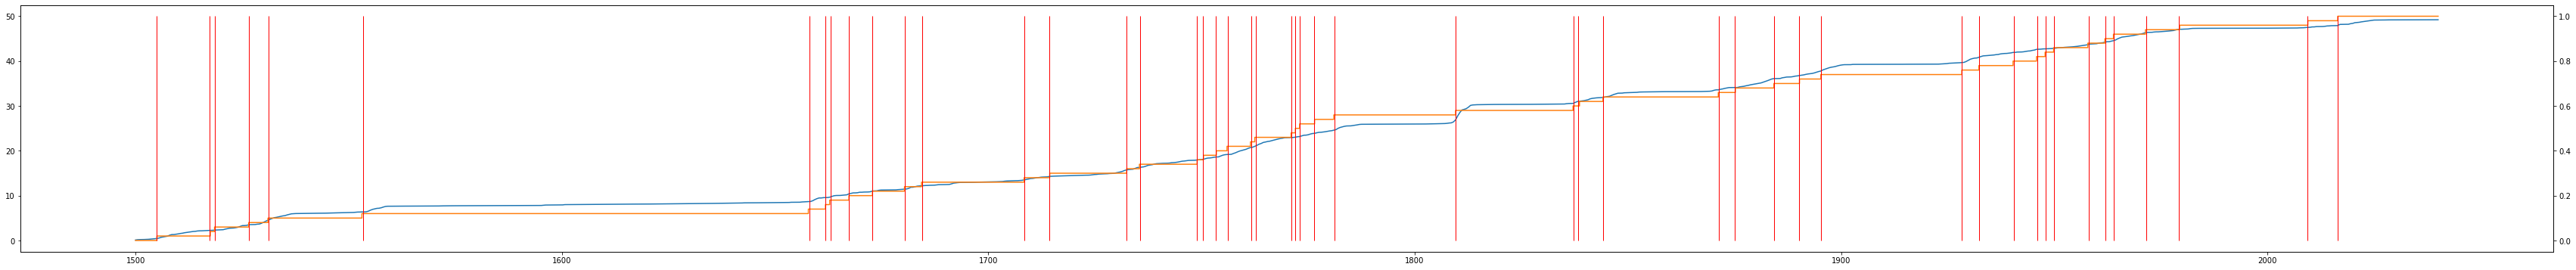

In [33]:
plot_nn_cumsum_2(params.val.time, params.val.events, results)

[38 28  8  2]


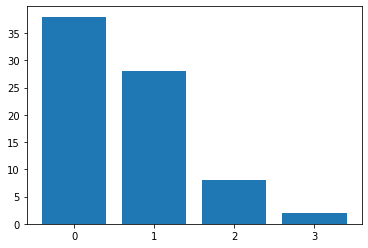

In [219]:
plot_events_density(loader)

In [4]:
files = [
    '20190819-Kutna Hora-L13-in-MVI_0006',
    '20190819-Kutna Hora-L14-in-SDV_0012', # 2 csv
    '20190819-Kutna Hora-L14-out-MVI_0005',
    '20190819-Kutna Hora-L1-out-MVI_0007',
    '20190819-Ricany-L2-in-MVI_0006', # 2 csv
    '20190819-Kutna Hora-L16-in-MVI_0038'
    '20190819-Kutna Hora-L2-in-MVI_0030'
]

# file = '20190819-Kutna Hora-L13-in-MVI_0006'
# file = '20190819-Kutna Hora-L2-in-MVI_0030'
file = '20190819-Kutna Hora-L4-out-MVI_0040'

signal = load_audio(f'data/audio/{file}.wav')
csv = load_csv(f'data/audio/{file}.MP4.csv')
events = load_events_from_csv(csv)
directions = load_direction_from_csv(csv)
signal_length = int(len(signal) / 44100)

print(file)
print(f'{signal_length / 60:.2f} min')

20190819-Kutna Hora-L4-out-MVI_0040
34.45 min


In [41]:
uuid = 1628542409
FROM_TIME = int(29 * 60)
# FROM_TIME = int(30 * 60)
# TILL_TIME = signal_length
TILL_TIME = int(31 * 60)
# TILL_TIME = int(32 * 60)

mask = (events >= FROM_TIME) & (events < TILL_TIME)
E = events[mask]
D = directions[mask]


manual_events = load_events('data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt')
mask = (manual_events >= FROM_TIME) & (manual_events < TILL_TIME)
manual_events = manual_events[mask]

results, params = inference(uuid, signal, FROM_TIME, TILL_TIME)

  0%|          | 0/119 [00:00<?, ?it/s]

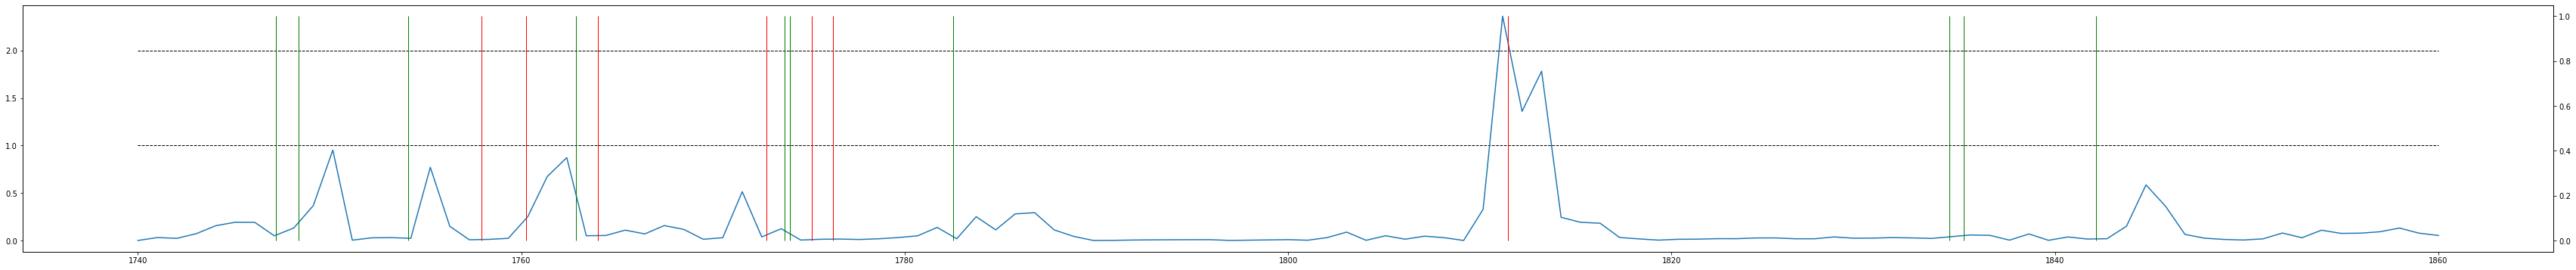

In [42]:
plot_nn_outputs(params.val.time, E, results, D)

diff: 2.1536


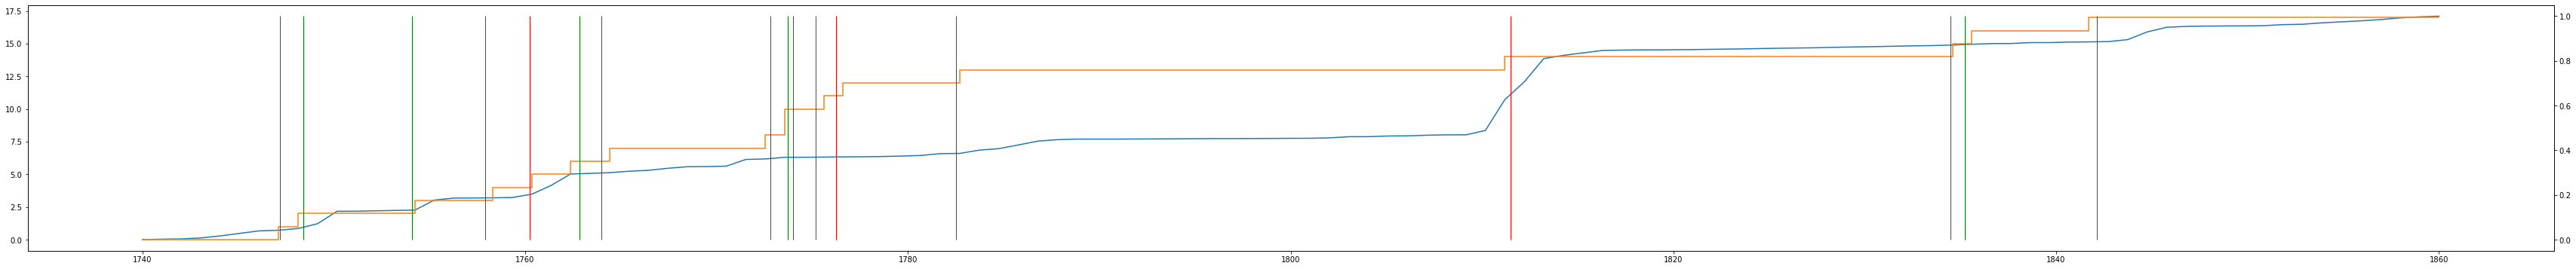

In [43]:
plot_nn_cumsum_2(params.val.time, E, results, D)

In [44]:
np.sum(results), len(E)

(17.098381973337382, 17)

In [45]:
csv[0, 8], csv[0, 9], csv[0, 14]

('Start time', 'End time', 'Best detection frame timestamp')

  0%|          | 0/100 [00:00<?, ?it/s]

obj: 173.8576 | const: 1.0101


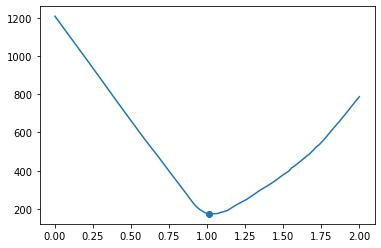

In [46]:
N = 8

discrete_events = discretize(params.val.time, E)

consts = np.linspace(0, 2, 100)
cumsum = np.cumsum(results)

best_obj = np.inf
best_const = None
objs = []
for const in tqdm(consts):
    cumsum_times_const = cumsum * const
    new_cumstep, new_discrete_events = dtw(discrete_events, cumsum_times_const, N)
    obj = np.abs(new_cumstep - cumsum_times_const).sum() 
    if obj < best_obj:
        best_obj = obj
        best_const = const
        
    objs.append(obj)
#     print(f'c: {const:.1f} | {obj:.3f}')

cumsum = cumsum * best_const
cumstep = get_cumstep(params.val.time, E)
new_cumstep, new_discrete_events = dtw(discrete_events, cumsum, N)

print(f'obj: {best_obj:.4f} | const: {best_const:.4f}')
plt.scatter([best_const], [best_obj])
plt.plot(consts, objs);

In [47]:
def get_melkwargs(params):
    return {
        "n_fft": params.n_fft,
        "n_mels": params.n_mels,
        "hop_length": params.hop_length
    }

def plot_nn_outputs_3(params, E, results, directions=None, warped=None, manual_events=None, 
                      cumsum=None, cumstep=None, new_cumstep=None):
    
    T = params.val.time

    fig, axes = plt.subplots(nrows=4, figsize=(int(params.val.time.size / 2), 4 * 3))
    
    ax0, ax1, ax2, ax3 = axes
    ax1_1 = ax1.twinx()
    
    for ax in axes:
        ax.margins(0, 0.02)
    
    markersize = 3
    
    # plot cumsum of nn output
    if cumsum is not None:
        ax0.plot(T, cumsum, marker='o', markersize=markersize);
      
    # plot sumstep of events
    if cumstep is not None:
        ax0.step(T, cumstep, where='post', marker='o', markersize=markersize);
    
    # plot sumstep of warped events
    if new_cumstep is not None:
        ax0.step(T, new_cumstep, where='post', linestyle='--', color='purple', marker='o', markersize=markersize);

    # plot nn output
    ax1.plot(T, results, marker='o', markersize=5)

    ax1.hlines(range(1, int(np.max(results)) + 1), T[0], T[-1], color='black', linestyle='--', linewidth=1.0)

    colors = 'red'
        
    if directions is not None:
        colors = []
        for i, event in enumerate(E):
            color = 'red' if directions[i] == 'outgoing' else 'green'
            colors.append(color)
    
    # plot events from eyedea
    ax1_1.vlines(E, 0, 1, color=colors, linewidth=2.0)
        
    # plot warped events
    if warped is not None:
        ax1_1.vlines(warped, 0, 1, color='magenta', linewidth=2.0)
         
    # plot manual annotations
    if manual_events is not None:
        ax1_1.vlines(manual_events, 0, 1, color='black', linestyle=':', linewidth=2.0)
    
    # plot signal amplitude
    ax2.plot(params.val.signal)
    
    # plot spectrogram
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=params.sr, **get_melkwargs(params))
    features = transform(params.val.signal).numpy()
    features = librosa.power_to_db(features, ref=np.max)
    
    ax3.pcolormesh(features)

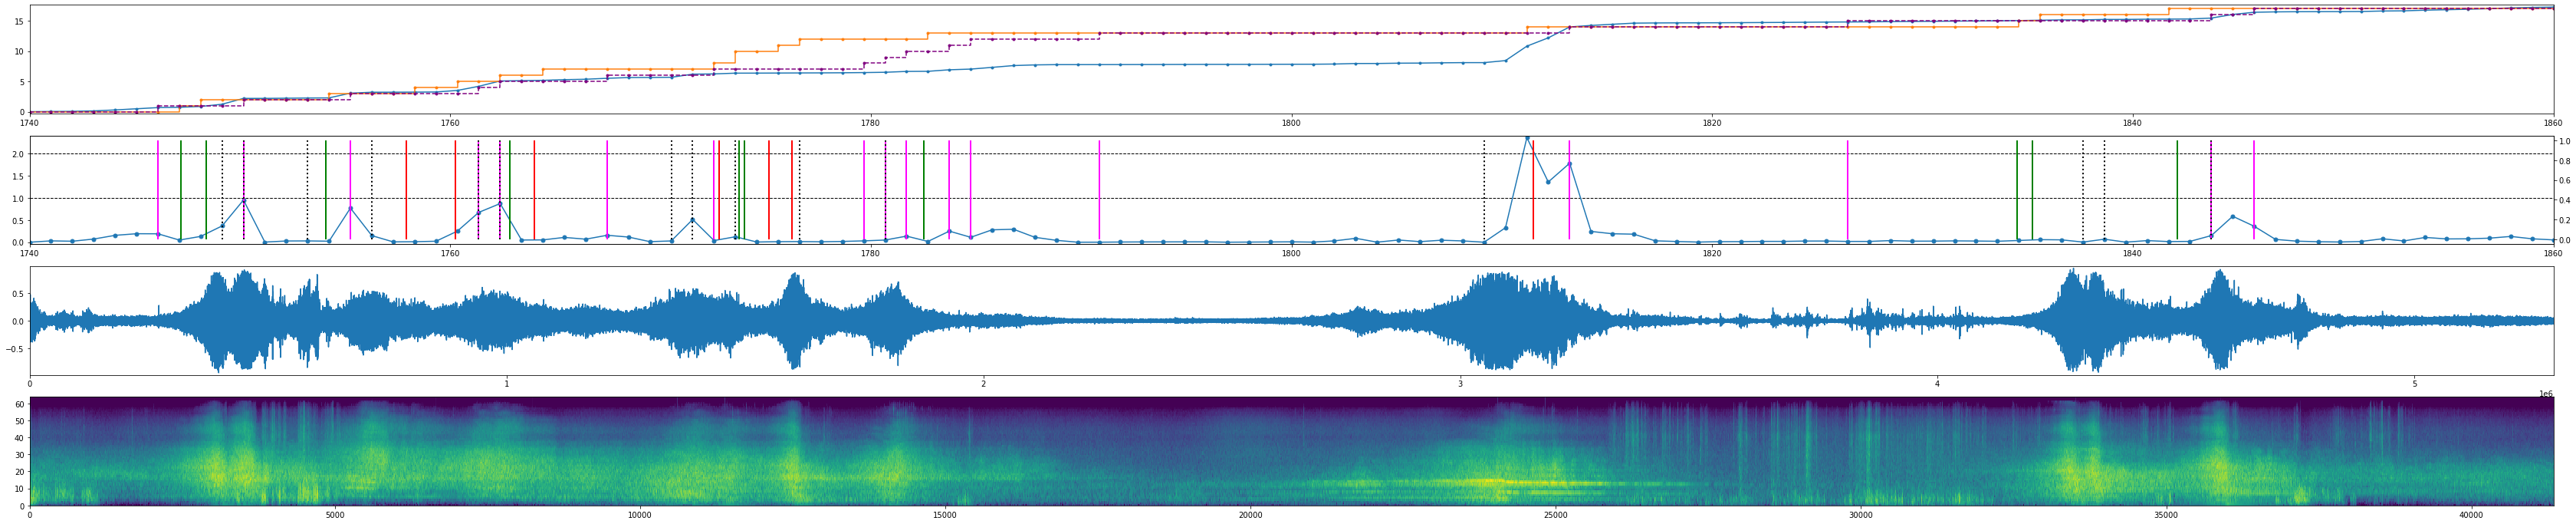

In [48]:
TIME_DIFF = params.val.time[1] - params.val.time[0]
new_events_in_seconds = new_discrete_events * TIME_DIFF
new_events_in_seconds += FROM_TIME

manual_events_discrete = discretize(params.val.time, manual_events)
manual_events_discrete_in_sec = manual_events_discrete * TIME_DIFF
manual_events_discrete_in_sec += FROM_TIME

plot_nn_outputs_3(
    params=params,
    E=E,
    results=results,
    directions=D,
    warped=new_events_in_seconds,
    manual_events=manual_events_discrete_in_sec,
    cumsum=cumsum,
    cumstep=cumstep,
    new_cumstep=new_cumstep
)